# Fermi-Hubbard Model

In [1]:
using Pkg; Pkg.activate()
using KadanoffBaym
using LinearAlgebra, BlockArrays
using UnPack
using JLD

  Activating environment at `~/.julia/environments/v1.6/Project.toml`


In [2]:
using PyPlot
PyPlot.plt.style.use("./paper.mplstyle")

## Model

Second-order Born approximation:
$$
    \Sigma_{ij, \uparrow}  (t, t') = U^2 G_{ij, \uparrow}(t, t') G_{ij, \downarrow}(t, t') G_{ji, \downarrow}(t', t),\\
    \Sigma_{ij, \downarrow}(t, t') = U^2 G_{ij, \downarrow}(t, t') G_{ij, \uparrow}(t, t') G_{ji, \uparrow}(t', t)
$$


$T$-matrix approximation:
$$
    \Sigma_{ij, \uparrow}  (t, t') = U^2 T_{ij}(t, t') G_{ji, \downarrow}(t', t),\\
    \Sigma_{ij, \downarrow}(t, t') = U^2 T_{ij}(t, t') G_{ji, \uparrow}(t', t)
$$

$$
   T_{ij}(t, t') =  G_{ij, \uparrow}(t, t') G_{ij, \downarrow}(t, t') + U \int_{\mathcal{C}}\mathrm{d}s\; G_{ij, \uparrow}(t, s) G_{ij, \downarrow}(t, s) T_{ij}(s, t')
$$

$t<t'$:
$$
    \int_{\mathcal{C}}\mathrm{d}s\; A(t, s) B(s, t') = \int_{t_0}^{t}{\mathrm{d}\bar{t}}  A^>(t, \bar{t}) B^<(\bar{t}, t') + \int_{t}^{t'}{\mathrm{d}\bar{t}}  A^<(t, \bar{t}) B^<(\bar{t}, t') + \int_{t'}^{t_0}{\mathrm{d}\bar{t}}  A^<(t, \bar{t}) B^>(\bar{t}, t')  
$$
$t>t'$:
$$
    \int_{\mathcal{C}}\mathrm{d}s\; A(t, s) B(s, t') = \int_{t_0}^{t'}{\mathrm{d}\bar{t}}  A^>(t, \bar{t}) B^<(\bar{t}, t') + \int_{t'}^{t}{\mathrm{d}\bar{t}}  A^>(t, \bar{t}) B^>(\bar{t}, t') + \int_{t}^{t_0}{\mathrm{d}\bar{t}}  A^<(t, \bar{t}) B^>(\bar{t}, t')  
$$

$$
    T^<_{ij}(t, t') =  G^<_{ij, \uparrow}(t, t') G^<_{ij, \downarrow}(t, t') + U \int_{t_0}^{t}{\mathrm{d}\bar{t}}\; G^>_{ij, \uparrow}(t, s) G^>_{ij, \downarrow}(t, s) T^<_{ij}(s, t') + U \int_{t}^{t'}{\mathrm{d}\bar{t}}\; G^<_{ij, \uparrow}(t, s) G^<_{ij, \downarrow}(t, s) T^<_{ij}(s, t') + U \int_{t'}^{t_0}{\mathrm{d}\bar{t}}\; G^<_{ij, \uparrow}(t, s) G^<_{ij, \downarrow}(t, s) T^>_{ij}(s, t')
$$

$$
    T^>_{ij}(t, t') =  G^>_{ij, \uparrow}(t, t') G^>_{ij, \downarrow}(t, t') + U \int_{t_0}^{t'}{\mathrm{d}\bar{t}}\; G^>_{ij, \uparrow}(t, s) G^>_{ij, \downarrow}(t, s) T^<_{ij}(s, t') + U \int_{t'}^{t}{\mathrm{d}\bar{t}}\; G^>_{ij, \uparrow}(t, s) G^>_{ij, \downarrow}(t, s) T^>_{ij}(s, t') + U \int_{t}^{t_0}{\mathrm{d}\bar{t}}\; G^<_{ij, \uparrow}(t, s) G^<_{ij, \downarrow}(t, s) T^>_{ij}(s, t')
$$

$$
    \dot{T}^<_{ij}(t, t') = \partial_t\left(G^<_{ij, \uparrow}(t, t') G^<_{ij, \downarrow}(t, t')\right) + U G^>_{ij, \uparrow}(t, t) G^>_{ij, \downarrow}(t, t) T^<_{ij}(t, t') - U G^<_{ij, \uparrow}(t, t) G^<_{ij, \downarrow}(t, t) T^<_{ij}(t, t') \\
    + U \int_{t_0}^{t}{\mathrm{d}\bar{t}}\; \partial_t\left(G^>_{ij, \uparrow}(t, t') G^>_{ij, \downarrow}(t, t')\right) T^<_{ij}(s, t') + U \int_{t}^{t'}{\mathrm{d}\bar{t}}\; \partial_t\left(G^<_{ij, \uparrow}(t, t') G^<_{ij, \downarrow}(t, t')\right) T^<_{ij}(s, t') + U \int_{t'}^{t_0}{\mathrm{d}\bar{t}}\; \partial_t\left(G^<_{ij, \uparrow}(t, t') G^<_{ij, \downarrow}(t, t')\right) T^>_{ij}(s, t')
$$

$$
    \dot{T}^>_{ij}(t, t') = \partial_t\left(G^>_{ij, \uparrow}(t, t') G^>_{ij, \downarrow}(t, t')\right) + U G^>_{ij, \uparrow}(t, t) G^>_{ij, \downarrow}(t, t) T^>_{ij}(t, t') - U G^<_{ij, \uparrow}(t, t) G^<_{ij, \downarrow}(t, t) T^>_{ij}(t, t') \\
    + U \int_{t_0}^{t'}{\mathrm{d}\bar{t}}\; \partial_t\left(G^>_{ij, \uparrow}(t, s) G^>_{ij, \downarrow}(t, s)\right) T^<_{ij}(s, t') + U \int_{t'}^{t}{\mathrm{d}\bar{t}}\; \partial_t\left(G^>_{ij, \uparrow}(t, s) G^>_{ij, \downarrow}(t, s)\right) T^<_{ij}(s, t') + U \int_{t}^{t_0}{\mathrm{d}\bar{t}}\; \partial_t\left(G^<_{ij, \uparrow}(t, s) G^<_{ij, \downarrow}(t, s)\right) T^>_{ij}(s, t')
$$

## Solving

In [3]:
Matrix{Float64} <: AbstractArray

true

In [4]:
function integrate(x::AbstractVector, y::AbstractVector)
    if isone(length(x))
        return zero(first(y))
    end

    @inbounds retval = (x[2] - x[1]) * (y[1] + y[2])
    @inbounds @fastmath @simd for i = 2:(length(y)-1)
        retval += (x[i+1] - x[i]) * (y[i] + y[i+1])
    end
    return 1 // 2 * retval
end;

function fixed_point(x0::AbstractArray, F::Function; 
        mixing::Float64=0.04, abstol::Float64=1e-9, maxiter::Int=1000, verbose::Bool=true, norm=x -> LinearAlgebra.norm(x, Inf))
  x_old = copy(x0)

  step = 0
  while step < maxiter
    x = F(x_old)
    res = norm(x - x_old)
    if verbose
      println("step: $step // res: $res")
    end
    if res < abstol
      break
    end
    @. x_old = mixing * x + (1.0 - mixing) * x_old
    step += 1
  end

  if step == maxiter
    println("No convergence reached.") 
  else
    println("Converged after $step steps.")
  end

  return x_old
end

fixed_point (generic function with 1 method)

In [5]:
num_sites = 2;

In [6]:
# 8-site 3D cubic lattice
h = BlockArray{ComplexF64}(undef_blocks, [4, 4], [4, 4])
diag_block = [0 -1 0 -1; -1 0 -1 0; 0 -1 0 -1; -1 0 -1 0]
setblock!(h, diag_block, 1, 1)
setblock!(h, diag_block, 2, 2)
setblock!(h, Diagonal(-1 .* ones(4)), 1, 2)
setblock!(h, Diagonal(-1 .* ones(4)), 2, 1)

full_h = BlockArray{ComplexF64}(undef_blocks, [8, 8], [8, 8])
setblock!(full_h, h |> Array, 1, 1)
setblock!(full_h, h |> Array, 2, 2)
setblock!(full_h, zeros(ComplexF64, 8, 8), 1, 2)
setblock!(full_h, zeros(ComplexF64, 8, 8), 2, 1)

full_h = full_h |> Array;

In [7]:
Base.@kwdef struct FermiHubbardModel
    U::Float64
    H = ComplexF64[0 -1 0 0; -1 0 0 0; 0 0 0 -1; 0 0 -1 0] # two-site 1D chain
    
    # 8-site 3D cubic lattice
#     H = full_h
end

FermiHubbardModel

In [8]:
struct FermiHubbardData{T}
    GL::T
    GG::T
    FL::T
    FG::T
    
    TL::T
    TG::T    
    
    ΣNCA_c_L::T
    ΣNCA_c_G::T
    ΣNCA_f_L::T
    ΣNCA_f_G::T
    
    # Initialize problem
    function FermiHubbardData(GL::T, GG::T, FL::T, FG::T, TL::T, TG::T) where T
        new{T}(GL, GG, FL, FG, zero(TL), zero(TG), zero(GL), zero(GG), zero(FL), zero(FG))
    end
end

In [9]:
function fv!(model, data, out, times, t, t′)
    @unpack GL, GG, FL, FG, TL, TG, ΣNCA_c_L, ΣNCA_c_G, ΣNCA_f_L, ΣNCA_f_G = data
    @unpack H, U = model 
    
    # real-time collision integral
    ∫dt(i, j, A, B) = sign(j - i) * integrate(times[min(i, j):max(i, j)],[A[t, s] * B[s, t′] for s = min(i, j):max(i, j)])
    
    ΣHF_c(t, t′) = 1.0im * U * Diagonal([FL[k, k, t, t] for k in 1:num_sites])
    ΣHF_f(t, t′) = 1.0im * U * Diagonal([GL[k, k, t, t] for k in 1:num_sites])
    
    out[1] = -1.0im * ((H[1:num_sites, 1:num_sites] + ΣHF_c(t, t′)) * GL[t, t′] + 
            ∫dt(1, t, ΣNCA_c_G, GL) + ∫dt(t, t′, ΣNCA_c_L, GL) - ∫dt(1, t′, ΣNCA_c_L, GG)
        )

    out[2] = -1.0im * ((H[1:num_sites, 1:num_sites] + ΣHF_c(t, t′)) * GG[t, t′] + 
            ∫dt(t′, t, ΣNCA_c_G, GG) - ∫dt(1, t, ΣNCA_c_L, GG) + ∫dt(1, t′, ΣNCA_c_G, GL)
        )

    out[3] = -1.0im * ((H[1 + num_sites:2 * num_sites, 1 + num_sites:2 * num_sites] + ΣHF_f(t, t′)) * FL[t, t′] + 
            ∫dt(1, t, ΣNCA_f_G, FL) + ∫dt(t, t′, ΣNCA_f_L, FL) - ∫dt(1, t′, ΣNCA_f_L, FG)
        )

    out[4] = -1.0im * ((H[1 + num_sites:2 * num_sites, 1 + num_sites:2 * num_sites] + ΣHF_f(t, t′)) * FG[t, t′] +
            ∫dt(t′, t, ΣNCA_f_G, FG) - ∫dt(1, t, ΣNCA_f_L, FG) + ∫dt(1, t′, ΣNCA_f_G, FL)
        )    
    
end

function fd!(model, data, out, times, t, t′)
    fv!(model, data, out, times, t, t)
    out[1:4] .-= adjoint.(out[1:4])
end

fd! (generic function with 1 method)

In [10]:
# function kernel_row(K::Function, grid::Vector{T}) where T
    
#     # auxiliary function to avoid crossing grid boundaries
#     check(grid, idx, inc) = !isassigned(grid, idx + inc) ? grid[idx] : grid[idx + inc]
    
#     return 0.5 .* [(check(grid, l, +1) - check(grid, l, -1)) .* K(grid[end], grid[l]) for l in 1:size(grid)[1]]
# end

function integrate(K::Function, u::S, grid::Vector{T}) where {T, S}
    # auxiliary function to avoid crossing grid boundaries
    check(grid, idx, inc) = !isassigned(grid, idx + inc) ? grid[idx] : grid[idx + inc]
    
    return 0.5 .* [(check(grid, l, +1) - check(grid, l, -1)) * K(size(grid)[1], l) * u[l] for l in 1:size(grid)[1]] |> sum   
end

integrate (generic function with 2 methods)

In [98]:
function self_energies!(model, data, times, t, t′)
    @unpack GL, GG, FL, FG, TL, TG, ΣNCA_c_L, ΣNCA_c_G, ΣNCA_f_L, ΣNCA_f_G = data
    @unpack U = model
        
    # real-time collision integral
    ∫dt(i, j, A, B) = sign(j - i) * integrate(times[min(i, j):max(i, j)], [A[t, s] * B[s, t′] for s = min(i, j):max(i, j)])    
#     ∫dt_(i, j, A, B) = sign(j - i) * integrate(A, [B[s, t′] for s = min(i, j):max(i, j)], times[min(i, j):max(i, j)])
    ∫dt_(i, j, A, B) = sign(j - i) * integrate(times[min(i, j):max(i, j)], [A(t, s) * B[s, t′] for s = min(i, j):max(i, j)])    
    ∫dt__(i, j, A, B) = sign(j - i) * integrate(times[min(i, j):max(i, j)], [A[t, s] * B(s, t′) for s = min(i, j):max(i, j)]) 

    if (n = size(GL, 3)) > size(ΣNCA_c_L, 3)
        resize!(ΣNCA_c_L, n)
        resize!(ΣNCA_c_G, n)
        resize!(ΣNCA_f_L, n)
        resize!(ΣNCA_f_G, n)
    end
    
    ΦL(t, t′) = -1.0im .* GL[t, t′] .* FL[t, t′]
    ΦG(t, t′) = -1.0im .* GG[t, t′] .* FG[t, t′]
    
    if t == t′
#         m = 0.5U .* [kernel_row(ΦL, 1:size(times)[1] |> collect), kernel_row(ΦG, 1:size(times)[1] |> collect)]
        x₀ = [ΦL(t, t), ΦG(t, t)]
        
        function F(x, i)
            TL[t, t′] = x[1]
            TG[t, t′] = x[2]
            
            return [
                    ΦL(t, t′) + 0.5U .* (∫dt__(1, i, TG, ΦL) - ∫dt_(1, i, ΦL, TG)), 
                    TG[t, t′]
                   ]
        end
#         F = x -> [
#                   x₀[1] + sum([m[1][1:t-1][i] * TG[1:t-1, t][i] - TG[t, 1:t-1][i] * m[1][1:t-1][i] for i in 1:t-1]) + (m[1][t] * x[2] - x[2] * m[1][t]),
#                   x₀[2] + sum([m[2][1:t-1][i] * TL[1:t-1, t][i] - TL[t, 1:t-1][i] * m[2][1:t-1][i] for i in 1:t-1]) + (m[2][t] * x[1] - x[1] * m[2][t])
#                  ]
#         F = x -> [
#                   x₀[1] + 0.5U .* ∫dt_(1, t-1, ΦL, TG) - 0.5U .* ∫dt_(1, t-1, TG, ΦL) + (m[1][t] * x[2] - x[2] * m[1][t]),
#                   x₀[2] + sum([m[2][1:t-1][i] * TL[1:t-1, t][i] - TL[t, 1:t-1][i] * m[2][1:t-1][i] for i in 1:t-1]) + (m[2][t] * x[1] - x[1] * m[2][t])
#                  ]        
#         println(round.(sum([m[1][1:t-1][i] * TG[1:t-1, t][i] for i in 1:t-1]), digits=10))
#         println(round.(0.5U .* ∫dt_(1, t-1, ΦL, TG), digits=10))
#         println(round.(0.5U .* ∫dt(1, t-1, TL, TG), digits=10), "\n")
        res = fixed_point(x₀, x -> F(x, t); mixing=0.5, verbose=false)
        println(res)
    end
    
    TL[t, t′] = -1.0im .* GL[t, t′] .* FL[t, t′]
    TG[t, t′] = -1.0im .* GG[t, t′] .* FG[t, t′]        
    
    ΣNCA_c_L[t, t′] = 1.0im .* U^2 .* TL[t, t′] .* transpose(FG[t′, t])
    ΣNCA_f_L[t, t′] = 1.0im .* U^2 .* TL[t, t′] .* transpose(GG[t′, t])
    
    ΣNCA_c_G[t, t′] = 1.0im .* U^2 .* TG[t, t′] .* transpose(FL[t′, t])
    ΣNCA_f_G[t, t′] = 1.0im .* U^2 .* TG[t, t′] .* transpose(GL[t′, t])
end

self_energies! (generic function with 1 method)

In [99]:
# known = zeros(n + 1)
# for i in 0:n
#     m = kernel_row(K, non_equi_grid[1:i+1])
#     x₀ = f(non_equi_grid[i+1])
#     F = x -> x₀ .+ sum(known[1:i] .* m[1:i]) .+ m[i+1] * x
#     known[i+1] = fixed_point([x₀], F; mixing=0.5, verbose=false)[1]
# end

In [100]:
# quantum numbers
dim = num_sites

# Define your Green functions at (t0, t0) – time arguments at the end
GL = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)
GG = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)
FL = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)
FG = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)

TL = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)
TG = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)

# Initial condition
N_c = zeros(num_sites)
N_f = zeros(num_sites)
N_c[1] = 0.8
N_f[2] = 0.2
# N_c[1:4] = [0.7, 0.0, 0.7, 0.0]
# N_f[1:4] = [0.0, 0.25, 0.0, 0.25]

# N_c[5:8] = [0.0, 0.4, 0.0, 0.4]
# N_f[5:8] = [0.65, 0.0, 0.65, 0.0]

GL[1, 1] = 1.0im * diagm(N_c)
GG[1, 1] = -1.0im * (I - diagm(N_c))
FL[1, 1] = 1.0im * diagm(N_f)
FG[1, 1] = -1.0im * (I - diagm(N_f))

data = FermiHubbardData(GL, GG, FL, FG, TL, TG)
model = FermiHubbardModel(U = 0.25)
# model = FermiHubbardModel(U = 1.)

data.TL[1, 1] = -1.0im .* GL[1, 1] .* FL[1, 1]
data.TG[1, 1] = -1.0im .* GG[1, 1] .* FG[1, 1]

tmax = 2;

In [101]:
atol = 1e-6
rtol = 1e-4;

# atol = 1e-5
# rtol = 1e-3;

In [102]:
@time sol = kbsolve!(
    (x...) -> fv!(model, data, x...),
    (x...) -> begin
#         println(" t: $(x[2][x[3]])")
        fd!(model, data, x...)
    end,
    [data.GL, data.GG, data.FL, data.FG, data.TL, data.TG],
    (0.0, tmax);
    callback = (x...) -> self_energies!(model, data, x...),
    atol = atol,
    rtol = rtol,
    dtini=1e-4
);

Converged after 0 steps.
Matrix{ComplexF64}[[0.0 + 0.0im 0.0 + 1.6000000000000003e-9im; 0.0 + 1.6000000000000003e-9im 0.0 + 0.0im], [0.0 + 0.19999999999999996im 0.0 + 1.5999999999999996e-9im; 0.0 + 1.5999999999999996e-9im 0.0 + 0.8im]]
Converged after 0 steps.
Matrix{ComplexF64}[[0.0 + 3.1999999360000005e-9im -4.7999999998800014e-14 + 6.399999999840001e-9im; 4.7999999998800014e-14 + 6.399999999840001e-9im 0.0 + 3.1999999360000005e-9im], [0.0 + 0.20000001519999988im -4.7999999998799995e-14 + 6.3999999998399995e-9im; 4.7999999998799995e-14 + 6.3999999998399995e-9im 0.0 + 0.7999999912im]]
Converged after 0 steps.
Matrix{ComplexF64}[[0.0 + 3.519999225520001e-8im -1.8479998799028022e-12 + 7.839999550324007e-8im; 1.8479998799028022e-12 + 7.839999550324007e-8im 0.0 + 3.519999225520001e-8im], [0.0 + 0.2000001671999922im -1.847999879902802e-12 + 7.839999550324004e-8im; 1.847999879902802e-12 + 7.839999550324004e-8im 0.0 + 0.7999999031999923im]]
Converged after 0 steps.
Matrix{ComplexF64}[[0.0 + 

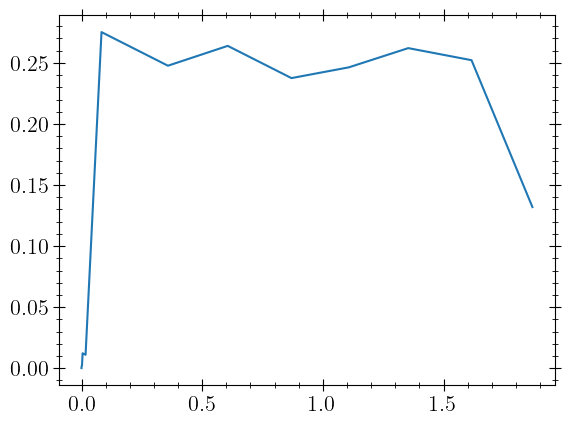

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1d33c18190>

In [97]:
plot(sol.t[1:end-1], sol.t |> diff)

In [84]:
# save("FH_1D_sol_U_"*string(model.U)*"_atol_1e-8_rtol_1e-6.jld", "solution", sol)
save("FH_3D_T_matrix_sol_U_"*string(model.U)*"_tmax_"*string(tmax)*"_atol_"*string(atol)*"_rtol_"*string(rtol)*".jld", "solution", sol)

In [311]:
data.TG[1:3, 1]

2×2×3 Array{ComplexF64, 3}:
[:, :, 1] =
 0.0+0.2im  0.0+0.0im
 0.0+0.0im  0.0+0.8im

[:, :, 2] =
 -8.0e-6+0.2im     4.0e-13-3.2e-8im
 1.0e-13-8.0e-9im  -8.0e-6+0.8im

[:, :, 3] =
   -2.8e-5+0.2im     3.29e-11-3.92e-7im
 8.225e-12-9.8e-8im   -2.8e-5+0.8im

In [303]:
[data.TG[1:3, 1][i] for i in 1:3]

3-element Vector{ComplexF64}:
 0.0 + 0.19999999999999996im
 0.0 + 0.0im
 0.0 + 0.0im

## Example plots

### Load data

In [51]:
# loaded_sol = load("FH_1D_sol_U_0.5_atol_1e-8_rtol_1e-6.jld")
loaded_sol = load("FH_3D_T_matrix_sol_U_"*string(model.U)*"_tmax_"*string(tmax)*"_atol_"*string(atol)*"_rtol_"*string(rtol)*".jld")

# U_0_sol = load("FH_sol_U_0.0_atol_1e-8_rtol_1e-6.jld");

In [52]:
num_points = (loaded_sol["solution"].t |> size)[1]

16

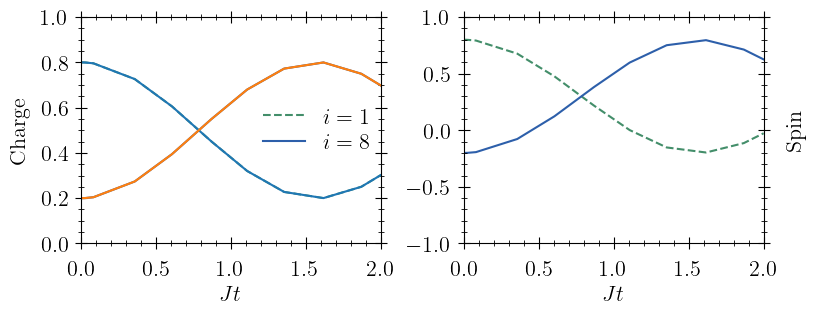

In [53]:
xpad = 8
ypad = 5

figure(figsize = (8, 3))

ax = subplot(121)
idx_1 = 1
idx_2 = 2

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_1, idx_1, k, k] .+ loaded_sol["solution"].u[3][idx_1, idx_1, k, k]) for k = 1:num_points], 
    label = "\$ i=1\$", lw=1.5, ls = "--", c = "#438E6A")

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_2, idx_2, k, k] .+ loaded_sol["solution"].u[3][idx_2, idx_2, k, k]) for k = 1:num_points], 
    label = "\$ i=8\$", lw=1.5, ls = "-", c = "#2D5FAA")

idx_1 = 1
idx_2 = 2

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_1, idx_1, k, k] .+ loaded_sol["solution"].u[3][idx_1, idx_1, k, k]) for k = 1:num_points]) 

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_2, idx_2, k, k] .+ loaded_sol["solution"].u[3][idx_2, idx_2, k, k]) for k = 1:num_points]) 


idx_1 = 1
idx_2 = 2


xlim(0, tmax)
# ax.set_xticks([0, 8, 16, 24, 32])
ylim(-0, 1)
xlabel("\$J t\$")
# ylabel("\$\\mathrm{Im}\\; G^<_{11, \\sigma}(t, t)\$")
ylabel("Charge", labelpad = 8)
ax.xaxis.set_tick_params(pad = xpad)
ax.yaxis.set_tick_params(pad = ypad)
# ax.set_axisbelow(false)
# ticklabel_format(axis = "y", style = "sci", scilimits = (-0, 0))
ax.legend(loc = "best", handlelength = 1.9, frameon = false, borderpad = 0, labelspacing = 0.25)

ax = subplot(122)

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_1, idx_1, k, k] .- loaded_sol["solution"].u[3][idx_1, idx_1, k, k]) for k = 1:num_points], 
    label = "\$ i=2\$", lw=1.5, ls = "--", c = "#438E6A")

plot(loaded_sol["solution"].t, [imag(loaded_sol["solution"].u[1][idx_2, idx_2, k, k] .- loaded_sol["solution"].u[3][idx_2, idx_2, k, k]) for k = 1:num_points], 
    label = "\$ i=2\$",  lw=1.5, ls = "-", c = "#2D5FAA")

xlim(0, tmax)
ylim(-1, 1)
# ax.set_xticks([0, 8, 16, 24, 32])
# ax.set_yticklabels([])
xlabel("\$J t\$")
ylabel("Spin", labelpad = 16)
ax.xaxis.set_tick_params(pad = xpad)
ax.yaxis.set_tick_params(pad = ypad)
ax.set_axisbelow(false)
# ticklabel_format(axis = "y", style = "sci", scilimits = (-0, 0))
# ax.legend( loc = "best", handlelength = 1.9, frameon = false, borderpad = 0, labelspacing = 0.25)
ax.yaxis.set_label_position("right")

tight_layout(pad = 0.1, w_pad = 0.5, h_pad = 0)
# savefig("fermi_hubbard_T.pdf")

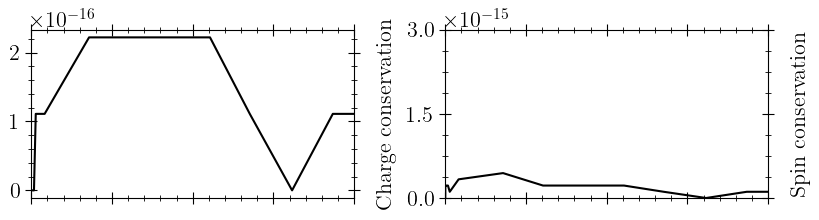

In [54]:
Gs = loaded_sol["solution"]

xpad = 8
ypad = 5

figure(figsize = (8, 2))

ax = subplot(121)
plot(loaded_sol["solution"].t, [(sum(Gs.u[1][i, i, k, k] for i = 1:num_sites) |> imag) .+ (sum(Gs.u[3][i, i, k, k] for i = 1:num_sites) |> imag) for k = 1:num_points] 
    .- sum(N_c .+ N_f)  .|> abs, 
    label = "\$ c \$", ls = "-", c = "k")
xlim(0, tmax)
# ax.set_xticks([0, 8, 16, 24, 32])
ax.set_xticklabels([])
# yticks([k for k in 0:0.5:1] .* 5e-15)
# ylim(0., 0.1)
ylabel("Charge conservation", labelpad = 16)
ax.yaxis.set_label_position("right")

ax = subplot(122)
plot(loaded_sol["solution"].t, [(sum(Gs.u[1][i, i, k, k] for i = 1:num_sites) |> imag) .- (sum(Gs.u[3][i, i, k, k] for i = 1:num_sites) |> imag) for k = 1:num_points] 
    .- sum(N_c .- N_f) .|> abs, 
    label = "\$ c \$", ls = "-", c = "k")
xlim(0, tmax)
# ax.set_xticks([0, 8, 16, 24, 32])
yticks([k for k in 0:0.5:1] .* 3e-15)
ax.set_xticklabels([])
# ax.set_yticklabels([])
ylim([0.0, 1] .* 3e-15)
ylabel("Spin conservation", labelpad = 16)
ax.yaxis.set_label_position("right")

tight_layout(pad = 0.0, w_pad = 0.5, h_pad = 0)
# savefig("fermi_hubbard_example_T_inset.pdf")

In [55]:
using FFTW, Interpolations

In [56]:
idx = 1
ρτ, (τs, ts) = wigner_transform_itp(FG[idx, idx, :, :] - FL[idx, idx, :, :], sol.t, fourier=false);
ρω, (ωs, ts) = wigner_transform_itp(FG[idx, idx, :, :] - FL[idx, idx, :, :], sol.t, fourier=true);

LoadError: UndefVarError: sol not defined

In [57]:
idx = 5
shift = 0
ρτ, (τs, ts) = wigner_transform_itp((loaded_sol["solution"].u[2][idx, idx, :, :] - loaded_sol["solution"].u[1][idx, idx, :, :])[1+shift:end-shift, 1+shift:end-shift], 
    loaded_sol["solution"].t[1+shift:end-shift], fourier=false);
ρω, (ωs, ts) = wigner_transform_itp((loaded_sol["solution"].u[2][idx, idx, :, :] - loaded_sol["solution"].u[1][idx, idx, :, :])[1+shift:end-shift, 1+shift:end-shift], 
    loaded_sol["solution"].t[1+shift:end-shift], fourier=true);

LoadError: BoundsError: attempt to access 2×2×16×16 Array{ComplexF64, 4} at index [5, 5, 1:16, 1:16]

In [58]:
τs |> size

LoadError: UndefVarError: τs not defined

In [59]:
ts |> size

LoadError: UndefVarError: ts not defined

In [60]:
t_scale = 1
ω_scale = 1;

In [61]:
xpad = 8
ypad = 5

center = floor(length(ts) / 2) |> Int
center |> print

figure(figsize=(8, 3))

ax = subplot(121)
plot(t_scale * τs, -ρτ[:, center] |> imag, ls="-", c="C0", lw=1.5)
ax.set_xlabel("\$J \\tau\$")
ax.set_xlim(-t_scale * tmax / 2, t_scale * tmax / 2)
# ax.set_ylim(-0.6, 1.0)
ax.set_xticks(t_scale .* [-tmax/2, -tmax/4, 0, tmax/4, tmax/2])
ax.xaxis.set_tick_params(pad=xpad)
ax.yaxis.set_tick_params(pad=ypad)
ax.set_ylabel("\$  A_{11, \\uparrow}(\\tau, T) \$")


ax = subplot(122)
plot(ω_scale * ωs, ρω[:, center] |> real, "-", c="C0", lw=1.5)

ax.xaxis.set_tick_params(pad=xpad)
ax.yaxis.set_tick_params(pad=ypad)
ax.set_xlabel("\$\\omega/J\$")
ax.set_ylabel("\$ A_{11,\\uparrow}(\\omega, T)\$", labelpad=16)
ax.set_xlim(5 .* (-1, 1))
# ax.set_ylim(0, 10)
ax.yaxis.set_label_position("right")
# ax.legend(loc="best", handlelength=1.4, frameon=false, borderpad=0, labelspacing=0.25)

tight_layout(pad=0.1, w_pad=0.5, h_pad=0)


# savefig("fermi_hubbard_example_tau_omega.pdf")

LoadError: UndefVarError: ts not defined

In [62]:
function meshgrid(xin,yin)
  nx=length(xin)
  ny=length(yin)
  xout=zeros(ny,nx)
  yout=zeros(ny,nx)
  for jx=1:nx
      for ix=1:ny
          xout[ix,jx]=xin[jx]
          yout[ix,jx]=yin[ix]
      end
  end
  return (x=xout, y=yout)
end

Y, X = meshgrid(loaded_sol["solution"].t, loaded_sol["solution"].t);

In [63]:
Y_gauss, X_gauss = meshgrid(U_0_sol["solution"].t, U_0_sol["solution"].t)
GL_gauss = U_0_sol["solution"].u[1]
GG_gauss = U_0_sol["solution"].u[2];

LoadError: UndefVarError: U_0_sol not defined

In [64]:
cmap = "gist_heat";

In [65]:
figure(figsize=(7, 3))
t_scale = 1
vmin = -1.0
vmax = 1.0

# ax = subplot(121) # plt.gca()
# heatmap = ax.pcolormesh(X_gauss, Y_gauss, imag(GL_gauss.data[1, 1, :, :]) .- imag(GG_gauss.data[1, 1, :, :]), cmap=cmap, rasterized=true, vmin=vmin, vmax=vmax)
# heatmap.set_edgecolor("face")
# ax.set_aspect("equal")
# # cbar = colorbar(mappable=heatmap)
# # cbar.formatter.set_powerlimits((0, 0))
# ax.set_xlabel("\$J t\$")
# ax.set_ylabel("\$J t'\$")
# ax.set_xlim(0, t_scale * tmax)
# ax.set_ylim(0, t_scale * tmax)
# ax.set_xticks(t_scale .* [0, tmax/2, tmax])
# ax.set_yticks(t_scale .* [0, tmax/2, tmax])

center = floor(length(ts) / 2) |> Int
center |> print


ax = subplot(121)
plot(t_scale * τs, -ρτ[:, center] |> imag, ls="-", c="C0", lw=1.5)
ax.set_xlabel("\$J \\tau\$")
ax.set_xlim(-t_scale * tmax / 2, t_scale * tmax / 2)
ax.set_ylim(-1, 1)
ax.set_xticks(t_scale .* [-tmax/2, -tmax/4, 0, tmax/4, tmax/2])
ax.xaxis.set_tick_params(pad=xpad)
ax.yaxis.set_tick_params(pad=ypad)
ax.set_ylabel("\$  A_{11, \\uparrow}(T_{\\mathrm{max}}/2, \\tau)_W \$")

ax = subplot(122)
heatmap = ax.pcolormesh(X, Y, imag(loaded_sol["solution"].u[1][1, 1, :, :]) .- imag(loaded_sol["solution"].u[2][1, 1, :, :]), cmap=cmap, rasterized=true, vmin=vmin, vmax=vmax)
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
cbar = colorbar(mappable=heatmap)
cbar.formatter.set_powerlimits((0, 0))
ax.set_xlabel("\$J t\$")
ax.set_ylabel("\$J t'\$")
ax.set_xlim(0, t_scale * tmax)
ax.set_ylim(0, t_scale * tmax)
ax.set_xticks(t_scale .* [0, tmax/2, tmax])
ax.set_yticks(t_scale .* [0, tmax/2, tmax])
# ax.set_yticklabels([])

tight_layout(pad=0.75, w_pad=0.5, h_pad=0)

# savefig("fermi_hubbard_example_two_times.pdf")

LoadError: UndefVarError: ts not defined

## Testing

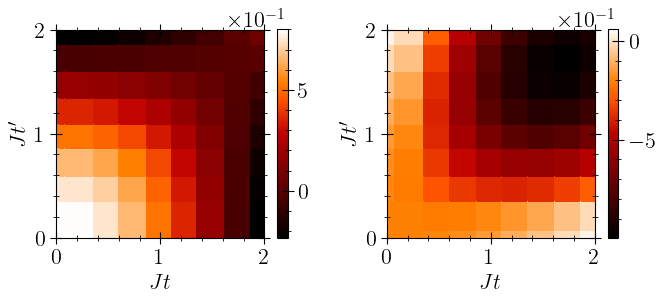

In [66]:
figure(figsize=(7, 3))
t_scale = 1
# vmin = -1.0
# vmax = 1.0

ax = subplot(121)
heatmap = ax.pcolormesh(X, Y, imag(loaded_sol["solution"].u[1][1, 1, :, :]), cmap=cmap, rasterized=true)#, vmin=vmin, vmax=vmax)
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
cbar = colorbar(mappable=heatmap)
cbar.formatter.set_powerlimits((0, 0))
ax.set_xlabel("\$J t\$")
ax.set_ylabel("\$J t'\$")
ax.set_xlim(0, t_scale * tmax)
ax.set_ylim(0, t_scale * tmax)
ax.set_xticks(t_scale .* [0, tmax/2, tmax])
ax.set_yticks(t_scale .* [0, tmax/2, tmax])

ax = subplot(122)
heatmap = ax.pcolormesh(X, Y, imag(loaded_sol["solution"].u[2][1, 1, :, :]), cmap=cmap, rasterized=true)#, vmin=vmin, vmax=vmax)
heatmap.set_edgecolor("face")
ax.set_aspect("equal")
cbar = colorbar(mappable=heatmap)
cbar.formatter.set_powerlimits((0, 0))
ax.set_xlabel("\$J t\$")
ax.set_ylabel("\$J t'\$")
ax.set_xlim(0, t_scale * tmax)
ax.set_ylim(0, t_scale * tmax)
ax.set_xticks(t_scale .* [0, tmax/2, tmax])
ax.set_yticks(t_scale .* [0, tmax/2, tmax])
# ax.set_yticklabels([])

tight_layout(pad=0.75, w_pad=0.5, h_pad=0)